<a href="https://colab.research.google.com/github/falilv41/weather_challenge/blob/main/ws_weather_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/ashenOne39/Weather_challenge

https://signate.jp/competitions/169/discussions/convolutional-lstm-1


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#ディレクトリ移動
%cd "/content/drive/My Drive/weather"

/content/drive/My Drive/weather


In [ ]:
#ドライブ内のファイルをcolab上にコピー
# !cp "/content/drive/My Drive/weather/sat.zip" .

In [ ]:
#zipファイルの解凍
# !unzip sat.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: sat/2017-09-13/2017-09-13-14-00.fv.png  
  inflating: __MACOSX/sat/2017-09-13/._2017-09-13-14-00.fv.png  
  inflating: sat/2017-09-13/2017-09-13-21-00.fv.png  
  inflating: __MACOSX/sat/2017-09-13/._2017-09-13-21-00.fv.png  
  inflating: sat/2017-09-13/2017-09-13-06-00.fv.png  
  inflating: __MACOSX/sat/2017-09-13/._2017-09-13-06-00.fv.png  
  inflating: sat/2017-09-13/2017-09-13-12-00.fv.png  
  inflating: __MACOSX/sat/2017-09-13/._2017-09-13-12-00.fv.png  
  inflating: sat/2017-09-13/2017-09-13-22-00.fv.png  
  inflating: __MACOSX/sat/2017-09-13/._2017-09-13-22-00.fv.png  
  inflating: sat/2017-09-13/2017-09-13-17-00.fv.png  
  inflating: __MACOSX/sat/2017-09-13/._2017-09-13-17-00.fv.png  
  inflating: sat/2017-09-13/2017-09-13-03-00.fv.png  
  inflating: __MACOSX/sat/2017-09-13/._2017-09-13-03-00.fv.png  
  inflating: sat/2017-09-13/2017-09-13-08-00.fv.png  
  inflating: __MACOSX/sat/2017-09-13/._2017-09-13-08-00.fv.png  
  inflating: sat

In [2]:
!pip install chainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967716 sha256=126524ebb227e49dc21dbf3b19738d93ba00b388e0c242944dbca5dd6a010d09
  Stored in directory: /root/.cache/pip/wheels/c4/95/6a/16014db6f761c4e742755b64aac60dbe142da1df6c5919f790
Successfully built chainer


In [3]:
import os
import numpy as np
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

import chainer
from chainer import training
from chainer import iterators, optimizers, serializers
from chainer import cuda
from chainer.training import extensions
from chainer import Variable
from chainer import variable
from chainer import reporter
from chainer import initializers
from chainer import Link, Chain
import chainer.functions as F
import chainer.links as L

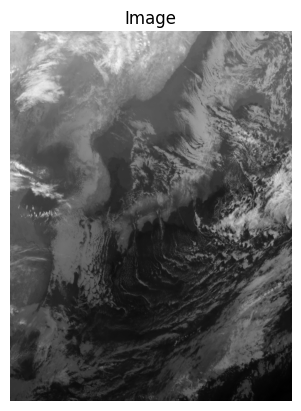

In [7]:
file = "sat/2016-01-01/2016-01-01-01-00.fv.png"
tmp = cv2.imread(file, 0)


# 画像が正しく読み込まれたか確認
if tmp is None:
    print("画像の読み込みに失敗しました。ファイルパスを確認してください。")
else:
    # 画像を表示する
    plt.imshow(tmp, cmap='gray')
    plt.title('Image')
    plt.axis('off')  # 軸を非表示にする
    plt.show()

In [8]:
# 2016-01-01-01以降のtrainデータから欠損ファイルの日付を探し出す関数
def find_missing_train_files():

    start_date = dt(2016, 1, 1, 1, 0, 0)
    missing_date = []

    for i in range(365*24*2):
        date = start_date + timedelta(hours=i)
        # file_name = "train/sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png".\
        file_name = "sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png".\
                    format(year=date.year, month=date.month, day=date.day, hour=date.hour)
        if not os.path.exists(file_name):
            missing_date.append(date)

    return missing_date

# testデータから欠損ファイルの日付を探し出す関数
# def find_missing_test_files():

#     terms = pd.read_csv('inference_terms.csv')
#     terms = pd.to_datetime(terms.iloc[:, 0])
#     missing_date = []

#     for i in range(50):

#         start_date = terms[i]

#         for j in range(96):

#             date = start_date + timedelta(hours=j)
#             file_name = "test/sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png".\
#                         format(year=date.year, month=date.month, day=date.day, hour=date.hour)

#             if not os.path.exists(file_name):
#                 missing_date.append(date)
#     return missing_date

# 2時間以上連続で欠損が続いているファイルを穴埋めするための関数
# 2016年2月15日16時のファイル
# 2017年2月13日15時のファイル
def fill_by_mean_2hours(date):

    file_name = "sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png".\
                    format(year=date.year, month=date.month, day=date.day, hour=date.hour)

    prev_date = date - timedelta(hours=2)
    next_date = date + timedelta(hours=2)

    prev_file = "sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png".\
                    format(year=prev_date.year, month=prev_date.month, day=prev_date.day, hour=prev_date.hour)
    next_file = "sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png".\
                    format(year=next_date.year, month=next_date.month, day=next_date.day, hour=next_date.hour)

    prev_img = cv2.imread(prev_file, 0)
    next_img = cv2.imread(next_file, 0)

    mean_img = (prev_img.astype('float32') + next_img.astype('float32')) / 2
    mean_img = mean_img.astype('uint8')

    cv2.imwrite(file_name, mean_img)

# fill_by_mean_2hours関数を実行
fill_by_mean_2hours(dt(2016, 2, 15, 16, 0, 0))
fill_by_mean_2hours(dt(2017, 2, 13, 15, 0, 0))

# 欠損ファイルを前後1時間の平均で埋める関数
def fill_by_mean(date,
                #  train_or_test=None
                 ):

    file_name = "sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png".\
                    format(
                           year=date.year, month=date.month, day=date.day, hour=date.hour)


    prev_date = date - timedelta(hours=1)
    next_date = date + timedelta(hours=1)

    prev_file_name = "sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png".\
                    format(
                           year=prev_date.year, month=prev_date.month, day=prev_date.day, hour=prev_date.hour)
    next_file_name = "sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png".\
                    format(
                           year=next_date.year, month=next_date.month, day=next_date.day, hour=next_date.hour)

    prev_img = cv2.imread(prev_file_name, 0)
    next_img = cv2.imread(next_file_name, 0)

    mean_img = (prev_img.astype('float32') + next_img.astype('float32')) / 2
    mean_img = mean_img.astype('uint8')

    cv2.imwrite(file_name, mean_img)

# find_missing_train_files, find_missing_test_files関数を実行し、欠損ファイルの日付をリスト化
train_missing_date_list = find_missing_train_files()
# test_missing_date_list = find_missing_test_files()
# 欠損ファイルのそれぞれの日付に対して、fill_by_mean関数を実行
for train_missing_date in train_missing_date_list:
    fill_by_mean(train_missing_date)

# for test_missing_date in test_missing_date_list:
#     fill_by_mean(test_missing_date, train_or_test='test')



# (2016, 1, 1, 0, 0)の画像の破損部分を前後1時間の平均で埋める関数
def fill_broken_part():
    broken_file = 'sat/2017-01-01/2017-01-01-00-00.fv.png'
    prev_file = 'sat/2016-12-31/2016-12-31-23-00.fv.png'
    next_file = 'sat/2017-01-01/2017-01-01-01-00.fv.png'

    broken_img = cv2.imread(broken_file, 0)
    prev_img = cv2.imread(prev_file, 0)
    next_img = cv2.imread(next_file, 0)

    mean_img = (prev_img.astype('float32') + next_img.astype('float32')) / 2
    mean_img = mean_img.astype('uint8')

    # 壊れている部分にのみ平均値を埋め込む
    new_img = np.concatenate([mean_img[:110], broken_img[110:]], axis=0)

    cv2.imwrite(broken_file, new_img)

# fill_broken_part関数を実行
fill_broken_part()




KeyboardInterrupt: 

In [ ]:
import shutil

# コピー元のファイルパス
source_file_path = 'sat/2016-01-01/2016-01-01-01-00.fv.png'
# コピー先のファイルパス（新しい名前）
destination_file_path = 'sat/2016-01-01/2016-01-01-00-00.fv.png'

# ファイルを複製して名前を変更
shutil.copy(source_file_path, destination_file_path)

print(f"ファイルを {source_file_path} から {destination_file_path} に複製しました。")


ファイルを sat/2016-01-01/2016-01-01-01-00.fv.png から sat/2016-01-01/2016-01-01-00-00.fv.png に複製しました。


In [9]:
ls sat/2016-01-01

2016-01-01-00-00.fv.png  2016-01-01-06-00.fv.png  2016-01-01-12-00.fv.png  2016-01-01-18-00.fv.png
2016-01-01-01-00.fv.png  2016-01-01-07-00.fv.png  2016-01-01-13-00.fv.png  2016-01-01-19-00.fv.png
2016-01-01-02-00.fv.png  2016-01-01-08-00.fv.png  2016-01-01-14-00.fv.png  2016-01-01-20-00.fv.png
2016-01-01-03-00.fv.png  2016-01-01-09-00.fv.png  2016-01-01-15-00.fv.png  2016-01-01-21-00.fv.png
2016-01-01-04-00.fv.png  2016-01-01-10-00.fv.png  2016-01-01-16-00.fv.png  2016-01-01-22-00.fv.png
2016-01-01-05-00.fv.png  2016-01-01-11-00.fv.png  2016-01-01-17-00.fv.png  2016-01-01-23-00.fv.png


In [12]:
# 衛星画像読み込みクラス
# all_days : スタートの日付を含む、取り扱う日数
# year, month, day : スタートの日付
# prev : 実況レンジ衛星画像コマ数
# post : 予測レンジ衛星画像コマ数
# step : 何日ごとにデータセットを作るか
# デフォルトでは2日分で1つのデータセットにしているので、all_daysは364でyear1年分のデータセットになる
# resize : 画像をリサイズ（縮小）する場合、縦横を何分の１にするか

class SatelliteImageDataset(chainer.dataset.DatasetMixin):
    def __init__(self, all_days=364, year=2017, month=1, day=1, hour=0, prev=24, post=24, step=1, resize=4):
        self.all_days = all_days
        self.year = year
        self.month = month
        self.day = day
        self.hour = hour
        self.prev = prev
        self.post = post
        self.step = step
        self.init_date = dt(year, month, day, hour, 0, 0)
        self.resize = resize

    def __len__(self):
        return self.all_days

    def get_example(self, i):
        # i はnumpy.int64型で、このままだとエラーになるのでint型にする
        start_date = self.init_date + timedelta(days=self.step * int(i))

        img_list = []
        for j in range(self.prev + self.post):
            date = start_date + timedelta(hours=j)
            file = "sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png".\
                        format(year=date.year, month=date.month, day=date.day, hour=date.hour)

            # グレースケールで画像を読み込む
            tmp = cv2.imread(file, 0)
            if tmp is None:
              raise ValueError(f"Failed to load image from {file}")

            if self.resize > 1:
                size = ( int(tmp.shape[1]/self.resize), int(tmp.shape[0]/self.resize) )
                tmp = cv2.resize(tmp, size)


            img_list.append( tmp )

        image = np.stack( img_list )
        image = image.reshape( *image.shape, 1 )
        # 学習用xと評価用tを正規化して返す
        return (image[:self.prev] / 255).astype(np.float32), (image[self.prev:] / 255).astype(np.float32)

In [11]:
# 2016-01-01/2016-01-01-01-00.fv.png
year=2016
month =1
day = 1
hour = 1

init_date = dt(year, month, day, hour, 0, 0)

start_date = init_date + timedelta(days=0)
date = start_date + timedelta(hours=0)
file = "sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png".format(year=date.year, month=date.month, day=date.day, hour=date.hour)

# print(file)
tmp_1 = cv2.imread(file, 0)
print(tmp_1)
tmp_1[0].shape


[[187 188 188 ... 132 131 140]
 [187 189 187 ... 132 139 155]
 [188 190 188 ... 132 135 157]
 ...
 [ 61  62  62 ...  25  25  25]
 [ 60  61  62 ...  25  25  25]
 [ 60  61  61 ...  25  25  25]]


(512,)

In [ ]:
a = SatelliteImageDataset()

In [ ]:
print(a)

In [13]:
# Convolutional LSTMセルのクラス

class ConvLSTMCell(Chain):
    # ksize : カーネルサイズ
    # inp_ch, hid_chはchannel数（hidden states）
    # padは、画像サイズを一定に保つためのpadding

    def __init__(self, inp_ch = 256, hid_ch = 128, ksize = 3):
        super(ConvLSTMCell, self).__init__()
        with self.init_scope():
            self.Wxi = L.Convolution2D(inp_ch, hid_ch, ksize, pad = ksize//2)
            self.Whi = L.Convolution2D(hid_ch, hid_ch, ksize, pad = ksize//2, nobias = True)
            self.Wxf = L.Convolution2D(inp_ch, hid_ch, ksize, pad = ksize//2)
            self.Whf = L.Convolution2D(hid_ch, hid_ch, ksize, pad = ksize//2, nobias = True)
            self.Wxc = L.Convolution2D(inp_ch, hid_ch, ksize, pad = ksize//2)
            self.Whc = L.Convolution2D(hid_ch, hid_ch, ksize, pad = ksize//2, nobias = True)
            self.Wxo = L.Convolution2D(inp_ch, hid_ch, ksize, pad = ksize//2)
            self.Who = L.Convolution2D(hid_ch, hid_ch, ksize, pad = ksize//2, nobias = True)

            Wci_initializer = initializers.Zero()
            self.Wci = variable.Parameter(Wci_initializer)
            Wcf_initializer = initializers.Zero()
            self.Wcf = variable.Parameter(Wcf_initializer)
            Wco_initializer = initializers.Zero()
            self.Wco = variable.Parameter(Wco_initializer)

        self.inp_ch = inp_ch
        self.hid_ch = hid_ch
        self.pc = None
        self.ph = None

    def reset_state(self, pc = None, ph = None):
        self.pc = pc
        self.ph = ph

    def initialize_params(self, shape):
        self.Wci.initialize((self.hid_ch, shape[2], shape[3]))
        self.Wcf.initialize((self.hid_ch, shape[2], shape[3]))
        self.Wco.initialize((self.hid_ch, shape[2], shape[3]))

    def initialize_state(self, shape):
        self.pc = Variable(self.xp.zeros((shape[0], self.hid_ch, shape[2], shape[3]), dtype = self.xp.float32))
        self.ph = Variable(self.xp.zeros((shape[0], self.hid_ch, shape[2], shape[3]), dtype = self.xp.float32))

    def __call__(self, x):
        if self.Wci.data is None:
            self.initialize_params(x.data.shape)

        if self.pc is None:
            self.initialize_state(x.data.shape)

        ci = F.sigmoid(self.Wxi(x) + self.Whi(self.ph) + F.scale(self.pc, self.Wci, 1))
        cf = F.sigmoid(self.Wxf(x) + self.Whf(self.ph) + F.scale(self.pc, self.Wcf, 1))
        cc = cf * self.pc + ci * F.tanh(self.Wxc(x) + self.Whc(self.ph))
        co = F.sigmoid(self.Wxo(x) + self.Who(self.ph) + F.scale(cc, self.Wco, 1))
        ch = co * F.tanh(cc)

        self.pc = cc
        self.ph = ch

        return ch

In [14]:
# Convolutional LSTM Network

class ConvLSTM_Network(Chain):
    # net_ch : 各ConvLSTMレイヤーでの、channel数（hidden states）を指定している
    # レイヤーの数だけのリスト

    def __init__(self, net_ch=[256, 128, 128], in_ch=1, out_ch=1, directory=None):
        super(ConvLSTM_Network, self).__init__()
        with self.init_scope():
            self.enc1 = ConvLSTMCell(in_ch, net_ch[0], 3)
            self.enc2 = ConvLSTMCell(net_ch[0], net_ch[1], 3)
            self.enc3 = ConvLSTMCell(net_ch[1], net_ch[2], 3)
            self.fcst1 = ConvLSTMCell(in_ch, net_ch[0], 3)
            self.fcst2 = ConvLSTMCell(net_ch[0], net_ch[1], 3)
            self.fcst3 = ConvLSTMCell(net_ch[1], net_ch[2], 3)
            self.last = L.Convolution2D(sum(net_ch), out_ch, 1)

        self.directory = directory

    def save_image(self, arr, filename):
        img = chainer.cuda.to_cpu(arr)
        img = img.astype(np.uint8)
        img = cv2.resize(img, (512, 672), interpolation = cv2.INTER_CUBIC)
        ret = cv2.imwrite(filename, img)

    def __call__(self, x, t):
        # x, tはそれぞれ、(バッチサイズ, フレーム数, 縦ピクセル数, 横ピクセル数, チャネル数)になっている

        self.enc1.reset_state()
        self.enc2.reset_state()
        self.enc3.reset_state()

        # フレームごとにループ（まずはインプットのx）
        for i in range(x.shape[1]):
            #  (batch_size, row, col, channel) -> (batch_size, channel, row, col)
            xi = F.transpose(x[:, i, :, :, :], (0, 3, 1, 2))

            h1 = self.enc1(xi)
            h2 = self.enc2(h1)
            self.enc3(h2)

        self.fcst1.reset_state(self.enc1.pc, self.enc1.ph)
        self.fcst2.reset_state(self.enc2.pc, self.enc2.ph)
        self.fcst3.reset_state(self.enc3.pc, self.enc3.ph)

        loss = None

        for i in range(t.shape[1]):
            # (batch_size, flame, row, col, channel)
            xs = x.shape

            # (batch_size, channel, row, col)
            h1 = self.fcst1(Variable(self.xp.zeros((xs[0], xs[4], xs[2], xs[3]), dtype=self.xp.float32)))
            h2 = self.fcst2(h1)
            h3 = self.fcst3(h2)

            # デフォルト axis=1 なので、channel方向にconcat
            h = F.concat((h1, h2, h3))
            pred = F.sigmoid( self.last(h) )

            # save output and teacher images
            if self.directory is not None:
                for j in range(t.shape[0]):
                    filename = self.directory + "fcst_frame_" + str(j) + "-" + str(i) + ".png"
                    self.save_image( (pred[j, 0, :, :].data * 255).astype(np.int32), filename )

            # 予測出力predは (batch_size, channel=1, row, col)
            # 真のデータtは (batch_size, flames=i, row, col, channel=1)
            cur_loss = F.mean_squared_error(t[:, i, :, :, 0], pred[:, 0, :, :])
            loss = cur_loss if loss is None else loss + cur_loss

        reporter.report({'loss': loss}, self)
        return loss

In [15]:
# データ読み込みIteratorと学習Trainer
# batch_size : バッチサイズ
# lr : Adamの学習率
# gpu : GPU環境であれば0, そうでなければ-1
# resize : 元画像を何分の1に小さくするか
# trained_model, save_model : 前回の学習済みモデルのパス、今回学習したモデルの出力先
# used_optimizer, save_optimizer : 前回保存したoptimizerのパス、今回使用したoptimizerの出力先
# prev_log, save_log : 前回保存したLogのcsvファイル、今回保存するLogのcsvの出力先
def Train_Model(batch_size = 4, lr = 0.001, epoch = 10, gpu = -1, resize=4,
                          trained_model = None, used_optimizer = None, prev_log = None,
                          save_model = None, save_optimizer = None, save_log = None):

    # データセットのクラスが返すデータのshape
    # (データセット数=日数, input/outputのフレーム, フレーム数, 画像の縦ピクセル数, 画像の横ピクセル数, チャネル数=1)
    # iteratorはnext()するたびにバッチサイズ分のサンプルを返す
    # (バッチサイズ, input/outputのフレーム, フレーム数, 画像の縦ピクセル数, 画像の横ピクセル数, チャネル数=1)
    # shuffle = False なら、日数の順に返してくれる
    train = SatelliteImageDataset(year=2016, resize=resize)
    train_iter = iterators.SerialIterator(train, batch_size=batch_size, shuffle=False)
    test = SatelliteImageDataset(year=2017, month=7, day=1, resize=resize, all_days=180)
    test_iter = iterators.SerialIterator(test, batch_size=batch_size, repeat=False, shuffle=False)

    # ネットワークの定義
    model = ConvLSTM_Network(net_ch=[64,64,64])

    # 学習済みモデルを読み込むかどうか
    if trained_model != None:
        print( "Load trained model : " + trained_model )
        serializers.load_npz(trained_model, model)

    # GPUを使うかどうか
    if gpu >= 0:
        cuda.get_device_from_id(gpu).use()
        model.to_gpu()

    # Optimizerの定義
    optimizer = optimizers.Adam(alpha=lr)
    optimizer.setup(model)

    if used_optimizer != None:
        print( "Load optimizer : " + used_optimizer )
        serializers.load_npz(used_optimizer, optimizer)

    print( "check learning rate : ", optimizer.alpha )

    # trainer設定と実行
    updater = training.StandardUpdater(train_iter, optimizer, device=gpu)
    trainer = training.Trainer(updater, (epoch, 'epoch'), out='results')

    trainer.extend(extensions.Evaluator(test_iter, model, device=gpu), trigger=(80, 'iteration'), name="validation")
    trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'main/loss', 'validation/main/loss']))
    logreport = extensions.LogReport(trigger=(80, 'iteration'))
    trainer.extend(logreport)

    trainer.run()

    if save_model != None:
        print( "Save model : " + save_model )
        serializers.save_npz(save_model, model)

    if save_optimizer != None:
        print( "Save optimizer : " + save_optimizer )
        serializers.save_npz(save_optimizer, optimizer)

    if save_log != None:
        print( "Save log report : " + save_log )
        log_df = pd.DataFrame(logreport.log)
        # 過去のログ読み込み
        if prev_log != None:
            tmp_log = pd.read_csv( prev_log )
            log_df["elapsed_time"] += tmp_log.iloc[-1, 0]
            log_df["epoch"] += tmp_log.iloc[-1, 1] + 1
            log_df["iteration"] += tmp_log.iloc[-1, 2]
            log_df = pd.concat([tmp_log, log_df])
        log_df.to_csv(save_log, index=False)

    return logreport

In [17]:
# ディレクトリの作成
base_dir = "/content/drive/My Drive/weather/output/"
save_dir = base_dir + "save/"
img_dir = base_dir + "image/"

# モデルとオプティマイザー保存先
if not os.path.exists( save_dir ):
    os.makedirs( save_dir )
# 作成画像保存先
if not os.path.exists( img_dir ):
    os.makedirs( img_dir )

In [ ]:
# 学習実行
logreport = Train_Model( epoch = 10,
                       batch_size = 1,
                       gpu = 0,
                       lr = 0.001,
                      #  trained_model = save_dir + "model_e20",
                      #  used_optimizer = save_dir + "optimizer_e20",
                      #  prev_log = save_dir + "log_e20.csv",
                       save_model = save_dir + "model_e10",
                       save_optimizer = save_dir + "optimizer_e10",
                       save_log = save_dir + "log_e10.csv",
                       resize = 4 )

check learning rate :  0.001
epoch       iteration   main/loss   validation/main/loss


In [ ]:
# 2016-01-01/2016-01-01-01-00.fv.png

In [ ]:
ls

__MACOSX/  output/  results/  sat/  sat.zip  ws_weather.ipynb


In [ ]:
# ログの可視化
plt.style.use('ggplot')
log_df = pd.read_csv( save_dir + 'log_e10.csv' )
pd.DataFrame(log_df[["main/loss", "validation/main/loss"]].values, columns=["main/loss", "validation/main/loss"],
                         index=log_df["iteration"]).plot(figsize=(10,7))